##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Training and evaluation with the built-in methods

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/keras/train_and_evaluate"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/snapshot-keras/site/en/guide/keras/train_and_evaluate.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/keras-team/keras-io/blob/master/guides/training_with_built_in_methods.py"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/keras/train_and_evaluate.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import numpy as np

## Introduction

This guide covers training, evaluation, and prediction (inference) models
when using built-in APIs for training & validation (such as `Model.fit()`,
`Model.evaluate()` and `Model.predict()`).

If you are interested in leveraging `fit()` while specifying your
own training step function, see the
[Customizing what happens in `fit()` guide](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit/).

If you are interested in writing your own training & evaluation loops from
scratch, see the guide
["writing a training loop from scratch"](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch/).

In general, whether you are using built-in loops or writing your own, model training &
evaluation works strictly in the same way across every kind of Keras model --
Sequential models, models built with the Functional API, and models written from
scratch via model subclassing.

This guide doesn't cover distributed training, which is covered in our
[guide to multi-GPU & distributed training](https://keras.io/guides/distributed_training/).

## API overview: a first end-to-end example

When passing data to the built-in training loops of a model, you should either use
**NumPy arrays** (if your data is small and fits in memory) or **`tf.data Dataset`
objects**. In the next few paragraphs, we'll use the MNIST dataset as NumPy arrays, in
order to demonstrate how to use optimizers, losses, and metrics.

모델의 내장 훈련 루프에 데이터를 전달할 때 NumPy 배열(데이터가 작고 메모리에 맞는 경우) 또는 tf.data Dataset 객체를 사용해야 합니다. 다음 몇 단락에서는 옵티마이저, 손실 및 메트릭을 사용하는 방법을 보여주기 위해 MNIST 데이터 세트를 NumPy 배열로 사용할 것입니다.

Let's consider the following model (here, we build in with the Functional API, but it
could be a Sequential model or a subclassed model as well):

In [3]:
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

Here's what the typical end-to-end workflow looks like, consisting of:

- Training
- Validation on a holdout set generated from the original training data
- Evaluation on the test data

We'll use MNIST data for this example.

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print("x_train type=", type(x_train))

print("x_train shape=", x_train.shape)
print("x_test shape=", x_test.shape)
print(y_train[0])

11490434/11490434 [==============================] - 0s 0us/step
x_train type= <class 'numpy.ndarray'>
x_train shape= (60000, 28, 28)
x_test shape= (10000, 28, 28)
5


In [5]:
# Preprocess the data (these are NumPy arrays)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# hold-out cross-validation
# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

We specify the training configuration (optimizer, loss, metrics):

In [6]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

We call `fit()`, which will train the model by slicing the data into "batches" of size
`batch_size`, and repeatedly iterating over the entire dataset for a given number of
`epochs`.

In [7]:
print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=4,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

Fit model on training data
Epoch 1/4
782/782 [==============================] - 3s 3ms/step - loss: 0.3348 - sparse_categorical_accuracy: 0.9034 - val_loss: 0.2088 - val_sparse_categorical_accuracy: 0.9375
Epoch 2/4
782/782 [==============================] - 4s 5ms/step - loss: 0.1584 - sparse_categorical_accuracy: 0.9526 - val_loss: 0.1633 - val_sparse_categorical_accuracy: 0.9517
Epoch 3/4
782/782 [==============================] - 2s 2ms/step - loss: 0.1142 - sparse_categorical_accuracy: 0.9656 - val_loss: 0.1120 - val_sparse_categorical_accuracy: 0.9694
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.0907 - sparse_categorical_accuracy: 0.9723 - val_loss: 0.1064 - val_sparse_categorical_accuracy: 0.9675


The returned `history` object holds a record of the loss values and metric values
during training:

In [8]:
history.history

{'loss': [0.3348022401332855,
  0.15839755535125732,
  0.11422082781791687,
  0.09068916738033295],
 'sparse_categorical_accuracy': [0.9033799767494202,
  0.9526399970054626,
  0.9655600190162659,
  0.972320020198822],
 'val_loss': [0.2087976336479187,
  0.16325178742408752,
  0.11203821003437042,
  0.10640773922204971],
 'val_sparse_categorical_accuracy': [0.9375,
  0.95169997215271,
  0.9693999886512756,
  0.9674999713897705]}

We evaluate the model on the test data via `evaluate()`:

In [9]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
79/79 [==============================] - 0s 2ms/step - loss: 0.1000 - sparse_categorical_accuracy: 0.9705
test loss, test acc: [0.10000088065862656, 0.9704999923706055]


In [10]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)
print(predictions[0])
print(np.argmax(predictions[0]))

Generate predictions for 3 samples
1/1 [==============================] - 0s 68ms/step
predictions shape: (3, 10)
[7.5045435e-08 2.3837440e-06 8.8247962e-06 1.6083507e-04 9.9996322e-10
 5.7993299e-07 1.5676887e-11 9.9982280e-01 4.7188519e-07 4.0000573e-06]
7


In [ ]:
x_test[:3].shape

(3, 784)

In [ ]:
x_test.shape

(10000, 784)

In [14]:
x_test[:1].shape

(1, 784)

In [15]:
predictions = model.predict(x_test[:1])
print(predictions)
print(np.argmax(predictions))

1/1 [==============================] - 0s 18ms/step
[[7.5045435e-08 2.3837440e-06 8.8247962e-06 1.6083493e-04 9.9996322e-10
  5.7993242e-07 1.5676916e-11 9.9982280e-01 4.7188522e-07 4.0000573e-06]]
7


In [16]:
predictions = model.predict(x_test[3:4])
print(predictions)
print(np.argmax(predictions))

1/1 [==============================] - 0s 17ms/step
[[9.9970621e-01 4.3200046e-08 4.2073003e-05 2.0773541e-06 5.9122176e-08
  1.4643086e-05 1.0500567e-04 4.6429923e-06 3.0343233e-07 1.2496683e-04]]
0


In [13]:
x_test[3:4].shape

(1, 784)

In [12]:
x_test[4].shape

(784,)

In [ ]:
predictions = model.predict(x_test[4])
print(predictions)
print(np.argmax(predictions))

Now, let's review each piece of this workflow in detail.

## The `compile()` method: specifying a loss, metrics, and an optimizer

To train a model with `fit()`, you need to specify a loss function, an optimizer, and
optionally, some metrics to monitor.

You pass these to the model as arguments to the `compile()` method:

In [19]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

In [18]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # metrics=[keras.metrics.Precision(name='precision'),
    #          keras.metrics.Recall(name='recall'),
    #          keras.metrics.FalsePositives(name='false_positives'),
    #          keras.metrics.FalseNegatives(name='false_negatives')]
)


In [20]:
print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=4,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

Fit model on training data
Epoch 1/4
782/782 [==============================] - 4s 4ms/step - loss: 0.0754 - sparse_categorical_accuracy: 0.9772 - val_loss: 0.1011 - val_sparse_categorical_accuracy: 0.9713
Epoch 2/4
782/782 [==============================] - 3s 4ms/step - loss: 0.0634 - sparse_categorical_accuracy: 0.9810 - val_loss: 0.1048 - val_sparse_categorical_accuracy: 0.9696
Epoch 3/4
782/782 [==============================] - 2s 3ms/step - loss: 0.0557 - sparse_categorical_accuracy: 0.9826 - val_loss: 0.1045 - val_sparse_categorical_accuracy: 0.9718
Epoch 4/4
782/782 [==============================] - 2s 3ms/step - loss: 0.0483 - sparse_categorical_accuracy: 0.9854 - val_loss: 0.0977 - val_sparse_categorical_accuracy: 0.9741


Metrics(측정항목)
메트릭은 모델의 성능을 판단하는 데 사용되는 함수입니다.

메트릭 함수는 모델을 훈련할 때 메트릭 평가 결과가 사용되지 않는다는 점을 제외하면 손실 함수와 유사합니다. 모든 손실 함수를 메트릭으로 사용할 수 있습니다.

The `metrics` argument should be a list -- your model can have any number of metrics.

If your model has multiple outputs, you can specify different losses and metrics for
each output, and you can modulate the contribution of each output to the total loss of
the model. You will find more details about this in the **Passing data to multi-input,
multi-output models** section.

Note that if you're satisfied with the default settings, in many cases the optimizer,
loss, and metrics can be specified via string identifiers as a shortcut:

In [21]:
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

For later reuse, let's put our model definition and compile step in functions; we will
call them several times across different examples in this guide.

In [22]:
def get_uncompiled_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(64, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    return model


### Many built-in optimizers, losses, and metrics are available

In general, you won't have to create your own losses, metrics, or optimizers
from scratch, because what you need is likely to be already part of the Keras API:

Optimizers:

- `SGD()` (with or without momentum)
- `RMSprop()`
- `Adam()`
- etc.

Losses:

- `MeanSquaredError()`
- `KLDivergence()`
- `CosineSimilarity()`
- etc.

Metrics:

- `AUC()`
- `Precision()`
- `Recall()`
- etc.

### Custom losses

If you need to create a custom loss, Keras provides two ways to do so.

The first method involves creating a function that accepts inputs `y_true` and
`y_pred`. The following example shows a loss function that computes the mean squared
error between the real data and the predictions:

In [23]:
def custom_mean_squared_error(y_true, y_pred):
    return tf.math.reduce_mean(tf.square(y_true - y_pred))

In [24]:
a = tf.keras.utils.to_categorical([0, 1, 2, 3], num_classes=4)
print(a)
print(type(a))

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
<class 'numpy.ndarray'>


In [25]:
print(y_train[0])
y_train_one_hot = tf.one_hot(y_train, depth=10)
print(y_train_one_hot[0])

5.0
tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32)


In [26]:
model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=custom_mean_squared_error)

In [27]:
# We need to one-hot encode the labels to use MSE
y_train_one_hot = tf.one_hot(y_train, depth=10) #keras.utils.to_categorical(y_train, 10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

782/782 [==============================] - 2s 2ms/step - loss: 0.0159


If you need a loss function that takes in parameters beside `y_true` and `y_pred`, you
can subclass the `tf.keras.losses.Loss` class and implement the following two methods:

- `__init__(self)`: accept parameters to pass during the call of your loss function
- `call(self, y_true, y_pred)`: use the targets (y_true) and the model predictions
(y_pred) to compute the model's loss

Let's say you want to use mean squared error, but with an added term that
will de-incentivize  prediction values far from 0.5 (we assume that the categorical
targets are one-hot encoded and take values between 0 and 1). This
creates an incentive for the model not to be too confident, which may help
reduce overfitting (we won't know if it works until we try!).

y_true 및 y_pred 외에 매개변수를 사용하는 손실 함수가 필요한 경우 tf.keras.losses.Loss 클래스를 하위 클래스로 분류하고 다음 두 가지 방법을 구현할 수 있습니다.

*  `__init__(self)`: 손실 함수 호출 중에 전달할 매개변수 수락
* `call(self, y_true, y_pred)`: 목표(y_true)와 모델 예측(y_pred)을 사용하여 모델의 손실을 계산합니다.


평균 제곱 오차를 사용하고 싶지만 0.5에서 멀리 떨어진 예측 값에 대한 인센티브를 제거하는 추가된 항이 있다고 가정해 보겠습니다(범주 대상은 원-핫 인코딩되고 0과 1 사이의 값을 취한다고 가정). 이것은 모델이 너무 자신감을 갖지 않도록 하는 인센티브를 생성하여 과적합을 줄이는 데 도움이 될 수 있습니다(해보기 전까지는 작동 여부를 알 수 없습니다!).

Here's how you would do it:

In [29]:
class CustomMSE(keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, name="custom_mse"):
        super().__init__(name=name)
        print("called __init__")
        self.regularization_factor = regularization_factor

    def call(self, y_true, y_pred):
        print("called call method")
        mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
        reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
        return mse + reg * self.regularization_factor

In [30]:
model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=CustomMSE())

called __init__


In [31]:
y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

called call method
called call method
782/782 [==============================] - 2s 2ms/step - loss: 0.0385


### Custom metrics

If you need a metric that isn't part of the API, you can easily create custom metrics
by subclassing the `tf.keras.metrics.Metric` class. You will need to implement 4
methods:

- `__init__(self)`, in which you will create state variables for your metric.
- `update_state(self, y_true, y_pred, sample_weight=None)`, which uses the targets
y_true and the model predictions y_pred to update the state variables.
- `result(self)`, which uses the state variables to compute the final results.
- `reset_state(self)`, which reinitializes the state of the metric.

State update and results computation are kept separate (in `update_state()` and
`result()`, respectively) because in some cases, the results computation might be very
expensive and would only be done periodically.

Here's a simple example showing how to implement a `CategoricalTruePositives` metric
that counts how many samples were correctly classified as belonging to a given class:

API의 일부가 아닌 메트릭이 필요한 경우 tf.keras.metrics.Metric 클래스를 서브클래싱하여 사용자 지정 메트릭을 쉽게 생성할 수 있습니다. 4가지 방법을 구현해야 합니다.

* __init__(self), 여기서 메트릭에 대한 상태 변수를 생성합니다.
* update_state(self, y_true, y_pred, sample_weight=None), 타겟 y_true와 모델 예측 y_pred를 사용하여 상태 변수를 업데이트합니다.
* result(self), 상태 변수를 사용하여 최종 결과를 계산합니다.
* reset_state(self), 메트릭 상태를 다시 초기화합니다.

상태 업데이트와 결과 계산은 별개로 유지됩니다(각각 update_state() 및 result()에서). 어떤 경우에는 결과 계산이 매우 비싸고 주기적으로만 수행되기 때문입니다.

다음은 주어진 클래스에 속하는 것으로 올바르게 분류된 샘플 수를 계산하는 CategoricalTruePositives 메트릭을 구현하는 방법을 보여주는 간단한 예입니다.

add_*

In [35]:
class CategoricalTruePositives(keras.metrics.Metric):
    def __init__(self, name="categorical_true_positives", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        print("update_state")
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")
        values = tf.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        print("result")
        return self.true_positives

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        print("reset_state")
        self.true_positives.assign(0.0)

In [37]:
model = get_uncompiled_model()
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CategoricalTruePositives()],
)
model.fit(x_train, y_train, batch_size=64, epochs=10)

Epoch 1/10
update_state
result
update_state
result
782/782 [==============================] - 2s 3ms/step - loss: 0.3445 - categorical_true_positives: 45083.0000
reset_state
Epoch 2/10
782/782 [==============================] - 2s 2ms/step - loss: 0.1676 - categorical_true_positives: 47500.0000
reset_state
Epoch 3/10
782/782 [==============================] - 2s 2ms/step - loss: 0.1189 - categorical_true_positives: 48196.0000
reset_state
Epoch 4/10
782/782 [==============================] - 2s 2ms/step - loss: 0.0934 - categorical_true_positives: 48602.0000
reset_state
Epoch 5/10
782/782 [==============================] - 2s 3ms/step - loss: 0.0776 - categorical_true_positives: 48862.0000
reset_state
Epoch 6/10
782/782 [==============================] - 2s 2ms/step - loss: 0.0652 - categorical_true_positives: 49010.0000
reset_state
Epoch 7/10
782/782 [==============================] - 2s 2ms/step - loss: 0.0568 - categorical_true_positives: 49138.0000
reset_state
Epoch 8/10
782/782 [==

### Handling losses and metrics that don't fit the standard signature

The overwhelming majority of losses and metrics can be computed from `y_true` and
`y_pred`, where `y_pred` is an output of your model -- but not all of them. For
instance, a regularization loss may only require the activation of a layer (there are
no targets in this case), and this activation may not be a model output.

In such cases, you can call `self.add_loss(loss_value)` from inside the call method of
a custom layer. Losses added in this way get added to the "main" loss during training
(the one passed to `compile()`). Here's a simple example that adds activity
regularization (note that activity regularization is built-in in all Keras layers --
this layer is just for the sake of providing a concrete example):

In [38]:
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs) * 0.1)
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert activity regularization as a layer
# x = ActivityRegularizationLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

# The displayed loss will be much higher than before
# due to the regularization component.
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 2s 2ms/step - loss: 0.3407


In [39]:
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs) * 0.1)
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

# The displayed loss will be much higher than before
# due to the regularization component.
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 2s 2ms/step - loss: 2.5423


You can do the same for logging metric values, using `add_metric()`:

In [40]:
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 2s 2ms/step - loss: 0.3395


In [41]:
class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        # The `aggregation` argument defines
        # how to aggregate the per-batch values
        # over each epoch:
        # in this case we simply average them.
        self.add_metric(
            keras.backend.std(inputs), name="std_of_activation", aggregation="mean"
        )
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert std logging as a layer.
x = MetricLoggingLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 3s 2ms/step - loss: 0.3581 - std_of_activation: 0.9942


In the [Functional API](https://www.tensorflow.org/guide/keras/functional/),
you can also call `model.add_loss(loss_tensor)`,
or `model.add_metric(metric_tensor, name, aggregation)`.

Here's a simple example:

In [42]:
inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x2 = layers.Dense(64, activation="relu", name="dense_2")(x1)
outputs = layers.Dense(10, name="predictions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

model.add_loss(tf.reduce_sum(x1) * 0.1)

model.add_metric(keras.backend.std(x1), name="std_of_activation", aggregation="mean")

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 2s 2ms/step - loss: 2.4770 - std_of_activation: 0.0018


Note that when you pass losses via `add_loss()`, it becomes possible to call
`compile()` without a loss function, since the model already has a loss to minimize.

Consider the following `LogisticEndpoint` layer: it takes as inputs
targets & logits, and it tracks a crossentropy loss via `add_loss()`. It also
tracks classification accuracy via `add_metric()`.

In [43]:
class LogisticEndpoint(keras.layers.Layer):
    def __init__(self, name=None):
        super(LogisticEndpoint, self).__init__(name=name)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
        self.accuracy_fn = keras.metrics.BinaryAccuracy()

    def call(self, targets, logits, sample_weights=None):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(targets, logits, sample_weights)
        self.add_loss(loss)

        # Log accuracy as a metric and add it
        # to the layer using `self.add_metric()`.
        acc = self.accuracy_fn(targets, logits, sample_weights)
        self.add_metric(acc, name="accuracy")

        # Return the inference-time prediction tensor (for `.predict()`).
        return tf.nn.softmax(logits)


You can use it in a model with two inputs (input data & targets), compiled without a
`loss` argument, like this:

In [44]:
import numpy as np

inputs = keras.Input(shape=(3,), name="inputs")
targets = keras.Input(shape=(10,), name="targets")
logits = keras.layers.Dense(10)(inputs)
predictions = LogisticEndpoint(name="predictions")(logits, targets)

model = keras.Model(inputs=[inputs, targets], outputs=predictions)
model.compile(optimizer="adam")  # No loss argument!

data = {
    "inputs": np.random.random((3, 3)),
    "targets": np.random.random((3, 10)),
}
model.fit(data)

1/1 [==============================] - 0s 389ms/step - loss: 1.1016 - binary_accuracy: 0.0000e+00


For more information about training multi-input models, see the section **Passing data
to multi-input, multi-output models**.

### Automatically setting apart a validation holdout set

In the first end-to-end example you saw, we used the `validation_data` argument to pass
a tuple of NumPy arrays `(x_val, y_val)` to the model for evaluating a validation loss
and validation metrics at the end of each epoch.

Here's another option: the argument `validation_split` allows you to automatically
reserve part of your training data for validation. The argument value represents the
fraction of the data to be reserved for validation, so it should be set to a number
higher than 0 and lower than 1. For instance, `validation_split=0.2` means "use 20% of
the data for validation", and `validation_split=0.6` means "use 60% of the data for
validation".

The way the validation is computed is by taking the last x% samples of the arrays
received by the `fit()` call, before any shuffling.

Note that you can only use `validation_split` when training with NumPy data.

처음 본 end-to-end 예제에서 validation_data 인수를 사용하여 각 epoch가 끝날 때 validation loss 및 validation metrics을 평가하기 위해 NumPy 배열(x_val, y_val)의 튜플을 모델에 전달했습니다.

여기 또 다른 옵션이 있습니다. validation_split 인수를 사용하면 validation을 위해 훈련 데이터의 일부를 자동으로 예약할 수 있습니다. 인수 값은 validation을 위해 예약된 데이터의 비율을 나타내므로 0보다 크고 1보다 작은 숫자로 설정해야 합니다. 예를 들어 validation_split=0.2는 "validation에 데이터의 20% 사용"을 의미하고, validation_split=0.6은 "validation을 위해 데이터의 60% 사용"을 의미합니다.

validation이 계산되는 방법은 셔플링 전에 fit() 호출에 의해 취하게된 배열의 마지막 x% 샘플을 취하는 것입니다.

NumPy 데이터로 훈련할 때만 validation_split을 사용할 수 있습니다.

In [45]:
model = get_compiled_model()
model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=1)

625/625 [==============================] - 2s 3ms/step - loss: 0.3749 - sparse_categorical_accuracy: 0.8948 - val_loss: 0.2204 - val_sparse_categorical_accuracy: 0.9358


## Training & evaluation from tf.data.Datasets

In the past few paragraphs, you've seen how to handle losses, metrics, and optimizers,
and you've seen how to use the `validation_data` and `validation_split` arguments in
`fit()`, when your data is passed as NumPy arrays.

Let's now take a look at the case where your data comes in the form of a
`tf.data.Dataset` object.

The `tf.data` API is a set of utilities in TensorFlow 2.0 for loading and preprocessing
data in a way that's fast and scalable.

For a complete guide about creating `Datasets`, see the
[tf.data documentation](https://www.tensorflow.org/guide/data).

You can pass a `Dataset` instance directly to the methods `fit()`, `evaluate()`, and
`predict()`:

In [46]:
model = get_compiled_model()

# First, let's create a training Dataset instance.
# For the sake of our example, we'll use the same MNIST data as before.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Now we get a test dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)

# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
model.fit(train_dataset, epochs=3)

Epoch 1/3
782/782 [==============================] - 2s 2ms/step - loss: 0.3416 - sparse_categorical_accuracy: 0.9029
Epoch 2/3
782/782 [==============================] - 2s 2ms/step - loss: 0.1635 - sparse_categorical_accuracy: 0.9518
Epoch 3/3
782/782 [==============================] - 2s 2ms/step - loss: 0.1201 - sparse_categorical_accuracy: 0.9643


In [47]:
# You can also evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

Evaluate
157/157 [==============================] - 0s 1ms/step - loss: 0.1316 - sparse_categorical_accuracy: 0.9610


{'loss': 0.13164903223514557,
 'sparse_categorical_accuracy': 0.9610000252723694}

Note that the Dataset is reset at the end of each epoch, so it can be reused of the
next epoch.

If you want to run training only on a specific number of batches from this Dataset, you
can pass the `steps_per_epoch` argument, which specifies how many training steps the
model should run using this Dataset before moving on to the next epoch.

If you do this, the dataset is not reset at the end of each epoch, instead we just keep
drawing the next batches. The dataset will eventually run out of data (unless it is an
infinitely-looping dataset).

In [ ]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Only use the 100 batches per epoch (that's 64 * 100 samples)
model.fit(train_dataset, epochs=3, steps_per_epoch=100)

Epoch 1/3
100/100 [==============================] - 1s 4ms/step - loss: 0.8049 - sparse_categorical_accuracy: 0.7900
Epoch 2/3
100/100 [==============================] - 0s 3ms/step - loss: 0.3670 - sparse_categorical_accuracy: 0.8975
Epoch 3/3
100/100 [==============================] - 0s 3ms/step - loss: 0.3130 - sparse_categorical_accuracy: 0.9091


### Using a validation dataset

You can pass a `Dataset` instance as the `validation_data` argument in `fit()`:

In [48]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=1, validation_data=val_dataset)

782/782 [==============================] - 4s 4ms/step - loss: 0.3323 - sparse_categorical_accuracy: 0.9065 - val_loss: 0.1865 - val_sparse_categorical_accuracy: 0.9492


At the end of each epoch, the model will iterate over the validation dataset and
compute the validation loss and validation metrics.

If you want to run validation only on a specific number of batches from this dataset,
you can pass the `validation_steps` argument, which specifies how many validation
steps the model should run with the validation dataset before interrupting validation
and moving on to the next epoch:

In [49]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(
    train_dataset,
    epochs=1,
    # Only run validation using the first 10 batches of the dataset
    # using the `validation_steps` argument
    validation_data=val_dataset,
    validation_steps=10,
)

782/782 [==============================] - 2s 3ms/step - loss: 0.3390 - sparse_categorical_accuracy: 0.9029 - val_loss: 0.3067 - val_sparse_categorical_accuracy: 0.9156


Note that the validation dataset will be reset after each use (so that you will always
be evaluating on the same samples from epoch to epoch).

The argument `validation_split` (generating a holdout set from the training data) is
not supported when training from `Dataset` objects, since this feature requires the
ability to index the samples of the datasets, which is not possible in general with
the `Dataset` API.

## Other input formats supported

Besides NumPy arrays, eager tensors, and TensorFlow `Datasets`, it's possible to train
a Keras model using Pandas dataframes, or from Python generators that yield batches of
data & labels.

In particular, the `keras.utils.Sequence` class offers a simple interface to build
Python data generators that are multiprocessing-aware and can be shuffled.

In general, we recommend that you use:

- NumPy input data if your data is small and fits in memory
- `Dataset` objects if you have large datasets and you need to do distributed training
- `Sequence` objects if you have large datasets and you need to do a lot of custom
Python-side processing that cannot be done in TensorFlow (e.g. if you rely on external libraries
for data loading or preprocessing).


## Using a `keras.utils.Sequence` object as input

`keras.utils.Sequence` is a utility that you can subclass to obtain a Python generator with
two important properties:

- It works well with multiprocessing.
- It can be shuffled (e.g. when passing `shuffle=True` in `fit()`).

A `Sequence` must implement two methods:

- `__getitem__`
- `__len__`

The method `__getitem__` should return a complete batch.
If you want to modify your dataset between epochs, you may implement `on_epoch_end`.

Here's a quick example:

```python
from skimage.io import imread
from skimage.transform import resize
import numpy as np

# Here, `filenames` is list of path to the images
# and `labels` are the associated labels.

class CIFAR10Sequence(Sequence):
    def __init__(self, filenames, labels, batch_size):
        self.filenames, self.labels = filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array([
            resize(imread(filename), (200, 200))
               for filename in batch_x]), np.array(batch_y)

sequence = CIFAR10Sequence(filenames, labels, batch_size)
model.fit(sequence, epochs=10)
```

## Using sample weighting and class weighting

With the default settings the weight of a sample is decided by its frequency
in the dataset. There are two methods to weight the data, independent of
sample frequency:

* Class weights
* Sample weights

### Class weights

This is set by passing a dictionary to the `class_weight` argument to
`Model.fit()`. This dictionary maps class indices to the weight that should
be used for samples belonging to this class.

This can be used to balance classes without resampling, or to train a
model that gives more importance to a particular class.

For instance, if class "0" is half as represented as class "1" in your data,
you could use `Model.fit(..., class_weight={0: 1., 1: 0.5})`.

Here's a NumPy example where we use class weights or sample weights to
give more importance to the correct classification of class #5 (which
is the digit "5" in the MNIST dataset).

In [50]:
import numpy as np

class_weight = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    # Set weight "2" for class "5",
    # making this class 2x more important
    5: 2.0,
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
}

print("Fit with class weight")
model = get_compiled_model()
model.fit(x_train, y_train, class_weight=class_weight, batch_size=64, epochs=1)

Fit with class weight
782/782 [==============================] - 3s 3ms/step - loss: 0.3772 - sparse_categorical_accuracy: 0.9014


### Sample weights

For fine grained control, or if you are not building a classifier,
you can use "sample weights".

- When training from NumPy data: Pass the `sample_weight`
  argument to `Model.fit()`.
- When training from `tf.data` or any other sort of iterator:
  Yield `(input_batch, label_batch, sample_weight_batch)` tuples.

A "sample weights" array is an array of numbers that specify how much weight
each sample in a batch should have in computing the total loss. It is commonly
used in imbalanced classification problems (the idea being to give more weight
to rarely-seen classes).

When the weights used are ones and zeros, the array can be used as a *mask* for
the loss function (entirely discarding the contribution of certain samples to
the total loss).

In [51]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

print("Fit with sample weight")
model = get_compiled_model()
model.fit(x_train, y_train, sample_weight=sample_weight, batch_size=64, epochs=1)

Fit with sample weight
782/782 [==============================] - 2s 2ms/step - loss: 0.3718 - sparse_categorical_accuracy: 0.9022


Here's a matching `Dataset` example:

In [52]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

# Create a Dataset that includes sample weights
# (3rd element in the return tuple).
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, sample_weight))

# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model = get_compiled_model()
model.fit(train_dataset, epochs=1)

782/782 [==============================] - 2s 2ms/step - loss: 0.3758 - sparse_categorical_accuracy: 0.9016


## Passing data to multi-input, multi-output models

In the previous examples, we were considering a model with a single input (a tensor of
shape `(764,)`) and a single output (a prediction tensor of shape `(10,)`). But what
about models that have multiple inputs or outputs?

Consider the following model, which has an image input of shape `(32, 32, 3)` (that's
`(height, width, channels)`) and a time series input of shape `(None, 10)` (that's
`(timesteps, features)`). Our model will have two outputs computed from the
combination of these inputs: a "score" (of shape `(1,)`) and a probability
distribution over five classes (of shape `(5,)`).

In [53]:
image_input = keras.Input(shape=(32, 32, 3), name="img_input")
timeseries_input = keras.Input(shape=(None, 10), name="ts_input") #timeseries : 시계열

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

# confidence score(localization) : object coordinate
score_output = layers.Dense(1, name="score_output")(x)
# classification
class_output = layers.Dense(5, name="class_output")(x)

model = keras.Model(
    inputs=[image_input, timeseries_input], outputs=[score_output, class_output]
)

Let's plot this model, so you can clearly see what we're doing here (note that the
shapes shown in the plot are batch shapes, rather than per-sample shapes).

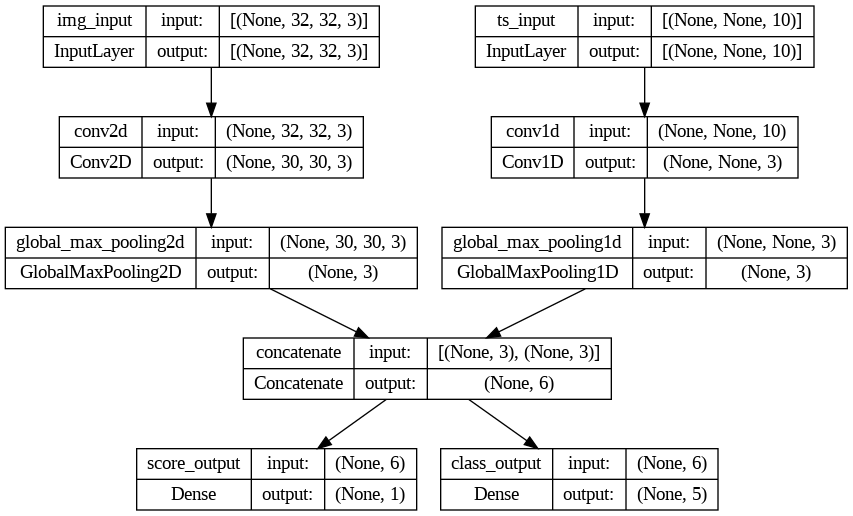

In [54]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

At compilation time, we can specify different losses to different outputs, by passing
the loss functions as a list:

In [55]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

If we only passed a single loss function to the model, the same loss function would be
applied to every output (which is not appropriate here).

Likewise for metrics:

In [56]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
    metrics=[
        [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        [keras.metrics.CategoricalAccuracy()],
    ],
)

Since we gave names to our output layers, we could also specify per-output losses and
metrics via a dict:

In [57]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
)

We recommend the use of explicit names and dicts if you have more than 2 outputs.

It's possible to give different weights to different output-specific losses (for
instance, one might wish to privilege the "score" loss in our example, by giving to 2x
the importance of the class loss), using the `loss_weights` argument:

In [58]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
    loss_weights={"score_output": 2.0, "class_output": 1.0},
)

You could also choose not to compute a loss for certain outputs, if these outputs are
meant for prediction but not for training:

In [59]:
# List loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy()],
)

# Or dict loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={"class_output": keras.losses.CategoricalCrossentropy()},
)

Passing data to a multi-input or multi-output model in `fit()` works in a similar way as
specifying a loss function in compile: you can pass **lists of NumPy arrays** (with
1:1 mapping to the outputs that received a loss function) or **dicts mapping output
names to NumPy arrays**.

In [60]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

# Generate dummy NumPy data
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

# Fit on lists
model.fit([img_data, ts_data], [score_targets, class_targets], batch_size=32, epochs=1)

4/4 [==============================] - 1s 13ms/step - loss: 18.3908 - score_output_loss: 0.4513 - class_output_loss: 17.9395


In [61]:
# Alternatively, fit on dicts
model.fit(
    {"img_input": img_data, "ts_input": ts_data},
    {"score_output": score_targets, "class_output": class_targets},
    batch_size=32,
    epochs=1,
)

4/4 [==============================] - 0s 9ms/step - loss: 18.6692 - score_output_loss: 0.3007 - class_output_loss: 18.3685


Here's the `Dataset` use case: similarly as what we did for NumPy arrays, the `Dataset`
should return a tuple of dicts.

In [62]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"img_input": img_data, "ts_input": ts_data},
        {"score_output": score_targets, "class_output": class_targets},
    )
)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model.fit(train_dataset, epochs=1)

2/2 [==============================] - 0s 15ms/step - loss: 19.0616 - score_output_loss: 0.2268 - class_output_loss: 18.8348


## Using callbacks

Callbacks in Keras are objects that are called at different points during training (at
the start of an epoch, at the end of a batch, at the end of an epoch, etc.). They
can be used to implement certain behaviors, such as:

- Doing validation at different points during training (beyond the built-in per-epoch
validation)
- Checkpointing the model at regular intervals or when it exceeds a certain accuracy
threshold
- Changing the learning rate of the model when training seems to be plateauing
- Doing fine-tuning of the top layers when training seems to be plateauing
- Sending email or instant message notifications when training ends or where a certain
performance threshold is exceeded
- Etc.

Callbacks can be passed as a list to your call to `fit()`:

In [63]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    )
]
model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
    validation_split=0.2,
)

Epoch 1/10
625/625 [==============================] - 2s 3ms/step - loss: 0.3766 - sparse_categorical_accuracy: 0.8931 - val_loss: 0.2219 - val_sparse_categorical_accuracy: 0.9338
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1704 - sparse_categorical_accuracy: 0.9490 - val_loss: 0.1766 - val_sparse_categorical_accuracy: 0.9467
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.1233 - sparse_categorical_accuracy: 0.9626 - val_loss: 0.1561 - val_sparse_categorical_accuracy: 0.9532
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0975 - sparse_categorical_accuracy: 0.9700 - val_loss: 0.1312 - val_sparse_categorical_accuracy: 0.9605
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0790 - sparse_categorical_accuracy: 0.9764 - val_loss: 0.1481 - val_sparse_categorical_accuracy: 0.9580
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0676 - sparse_categorica

### Many built-in callbacks are available

There are many built-in callbacks already available in Keras, such as:

- `ModelCheckpoint`: Periodically save the model.
- `EarlyStopping`: Stop training when training is no longer improving the validation
metrics.
- `TensorBoard`: periodically write model logs that can be visualized in
[TensorBoard](https://www.tensorflow.org/tensorboard) (more details in the section
"Visualization").
- `CSVLogger`: streams loss and metrics data to a CSV file.
- etc.

See the [callbacks documentation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/) for the complete list.

### Writing your own callback

You can create a custom callback by extending the base class
`keras.callbacks.Callback`. A callback has access to its associated model through the
class property `self.model`.

Make sure to read the
[complete guide to writing custom callbacks](https://www.tensorflow.org/guide/keras/custom_callback/).

Here's a simple example saving a list of per-batch loss values during training:

In [64]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))


## Checkpointing models

When you're training model on relatively large datasets, it's crucial to save
checkpoints of your model at frequent intervals.

The easiest way to achieve this is with the `ModelCheckpoint` callback:

In [69]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath="mymodel_{epoch}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    )
]
model.fit(
    x_train, y_train, epochs=10, batch_size=64, callbacks=callbacks, validation_split=0.2
)

Epoch 1/10
608/625 [============================>.] - ETA: 0s - loss: 0.3638 - sparse_categorical_accuracy: 0.8969
Epoch 1: val_loss improved from inf to 0.23144, saving model to mymodel_1


625/625 [==============================] - 3s 4ms/step - loss: 0.3600 - sparse_categorical_accuracy: 0.8981 - val_loss: 0.2314 - val_sparse_categorical_accuracy: 0.9334
Epoch 2/10
621/625 [============================>.] - ETA: 0s - loss: 0.1709 - sparse_categorical_accuracy: 0.9495
Epoch 2: val_loss improved from 0.23144 to 0.17171, saving model to mymodel_2


625/625 [==============================] - 3s 4ms/step - loss: 0.1703 - sparse_categorical_accuracy: 0.9498 - val_loss: 0.1717 - val_sparse_categorical_accuracy: 0.9489
Epoch 3/10
610/625 [============================>.] - ETA: 0s - loss: 0.1260 - sparse_categorical_accuracy: 0.9624
Epoch 3: val_loss improved from 0.17171 to 0.15965, saving model to mymodel_3


625/625 [==============================] - 2s 4ms/step - loss: 0.1255 - sparse_categorical_accuracy: 0.9624 - val_loss: 0.1597 - val_sparse_categorical_accuracy: 0.9512
Epoch 4/10
621/625 [============================>.] - ETA: 0s - loss: 0.0987 - sparse_categorical_accuracy: 0.9706
Epoch 4: val_loss improved from 0.15965 to 0.15030, saving model to mymodel_4


625/625 [==============================] - 2s 4ms/step - loss: 0.0988 - sparse_categorical_accuracy: 0.9707 - val_loss: 0.1503 - val_sparse_categorical_accuracy: 0.9557
Epoch 5/10
611/625 [============================>.] - ETA: 0s - loss: 0.0813 - sparse_categorical_accuracy: 0.9760
Epoch 5: val_loss improved from 0.15030 to 0.13936, saving model to mymodel_5


625/625 [==============================] - 2s 4ms/step - loss: 0.0809 - sparse_categorical_accuracy: 0.9761 - val_loss: 0.1394 - val_sparse_categorical_accuracy: 0.9603
Epoch 6/10
605/625 [============================>.] - ETA: 0s - loss: 0.0668 - sparse_categorical_accuracy: 0.9791
Epoch 6: val_loss improved from 0.13936 to 0.13362, saving model to mymodel_6


625/625 [==============================] - 2s 3ms/step - loss: 0.0671 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.1336 - val_sparse_categorical_accuracy: 0.9627
Epoch 7/10
619/625 [============================>.] - ETA: 0s - loss: 0.0562 - sparse_categorical_accuracy: 0.9830
Epoch 7: val_loss improved from 0.13362 to 0.12908, saving model to mymodel_7


625/625 [==============================] - 3s 4ms/step - loss: 0.0563 - sparse_categorical_accuracy: 0.9829 - val_loss: 0.1291 - val_sparse_categorical_accuracy: 0.9633
Epoch 8/10
612/625 [============================>.] - ETA: 0s - loss: 0.0481 - sparse_categorical_accuracy: 0.9862
Epoch 8: val_loss did not improve from 0.12908
625/625 [==============================] - 2s 3ms/step - loss: 0.0481 - sparse_categorical_accuracy: 0.9862 - val_loss: 0.1429 - val_sparse_categorical_accuracy: 0.9621
Epoch 9/10
623/625 [============================>.] - ETA: 0s - loss: 0.0422 - sparse_categorical_accuracy: 0.9874
Epoch 9: val_loss did not improve from 0.12908
625/625 [==============================] - 2s 3ms/step - loss: 0.0421 - sparse_categorical_accuracy: 0.9874 - val_loss: 0.1361 - val_sparse_categorical_accuracy: 0.9667
Epoch 10/10
614/625 [============================>.] - ETA: 0s - loss: 0.0370 - sparse_categorical_accuracy: 0.9888
Epoch 10: val_loss did not improve from 0.12908
625/6

In [66]:
!rm -r ./mymodel_1/

In [67]:
!rm -r ./mymodel_2/

In [68]:
!ls -al

total 68
drwxr-xr-x 1 root root  4096 Feb 14 06:25 .
drwxr-xr-x 1 root root  4096 Feb 14 02:31 ..
drwxr-xr-x 4 root root  4096 Feb 10 14:33 .config
-rw-r--r-- 1 root root 50981 Feb 14 05:48 multi_input_and_output_model.png
drwxr-xr-x 1 root root  4096 Feb 10 14:33 sample_data


The `ModelCheckpoint` callback can be used to implement fault-tolerance:
the ability to restart training from the last saved state of the model in case training
gets randomly interrupted. Here's a basic example:

In [70]:
import os

In [71]:
!pwd

/content


In [72]:
!ls -al

total 96
drwxr-xr-x 1 root root  4096 Feb 14 06:25 .
drwxr-xr-x 1 root root  4096 Feb 14 02:31 ..
drwxr-xr-x 4 root root  4096 Feb 10 14:33 .config
-rw-r--r-- 1 root root 50981 Feb 14 05:48 multi_input_and_output_model.png
drwxr-xr-x 4 root root  4096 Feb 14 06:25 mymodel_1
drwxr-xr-x 4 root root  4096 Feb 14 06:25 mymodel_2
drwxr-xr-x 4 root root  4096 Feb 14 06:25 mymodel_3
drwxr-xr-x 4 root root  4096 Feb 14 06:25 mymodel_4
drwxr-xr-x 4 root root  4096 Feb 14 06:25 mymodel_5
drwxr-xr-x 4 root root  4096 Feb 14 06:25 mymodel_6
drwxr-xr-x 4 root root  4096 Feb 14 06:25 mymodel_7
drwxr-xr-x 1 root root  4096 Feb 10 14:33 sample_data


In [73]:
# Prepare a directory to store all the checkpoints.
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [74]:
def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    # ./ckpt/name...
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    print("checkpoints=", checkpoints)
    print("checkpoints size=", len(checkpoints))
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)

    print("Creating a new model")
    
    return get_compiled_model()

In [75]:
model = make_or_restore_model()

checkpoints= []
checkpoints size= 0
Creating a new model


In [ ]:
callbacks = [
    # This callback saves a SavedModel every 100 batches.
    # We include the training loss in the saved model name.
    # checkpoint_dir = ./ckpt2
    # ./ckpt/ckpt-loss=0.xx
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir + "/ckpt-loss={loss:.2f}", save_freq=100
    )
]
model.fit(x_train, y_train, epochs=1, callbacks=callbacks)

In [77]:
model2 = make_or_restore_model()

checkpoints= ['./ckpt/ckpt-loss=0.40', './ckpt/ckpt-loss=0.48', './ckpt/ckpt-loss=0.38', './ckpt/ckpt-loss=0.35', './ckpt/ckpt-loss=0.71', './ckpt/ckpt-loss=0.37', './ckpt/ckpt-loss=0.98', './ckpt/ckpt-loss=0.32', './ckpt/ckpt-loss=0.33', './ckpt/ckpt-loss=0.43', './ckpt/ckpt-loss=0.53', './ckpt/ckpt-loss=0.31', './ckpt/ckpt-loss=0.59', './ckpt/ckpt-loss=0.45', './ckpt/ckpt-loss=0.34']
checkpoints size= 15
Restoring from ./ckpt/ckpt-loss=0.31


You call also write your own callback for saving and restoring models.

For a complete guide on serialization and saving, see the
[guide to saving and serializing Models](https://www.tensorflow.org/guide/keras/save_and_serialize/).

## Using learning rate schedules

A common pattern when training deep learning models is to gradually reduce the learning
as training progresses. This is generally known as "learning rate decay".

The learning decay schedule could be static (fixed in advance, as a function of the
current epoch or the current batch index), or dynamic (responding to the current
behavior of the model, in particular the validation loss).

### Passing a schedule to an optimizer

You can easily use a static learning rate decay schedule by passing a schedule object
as the `learning_rate` argument in your optimizer:

step = ?
50,000

```python
def decayed_learning_rate(step): \
  return initial_learning_rate * decay_rate ^ (step / decay_steps)
```

If the argument staircase is True, then step / decay_steps is an integer division and the decayed learning rate follows a staircase function.\
(staircase 인수가 True이면 step/decay_steps는 정수 나눗셈이고 감소된 학습률은 계단 함수를 따릅니다.)

step = 15,630 \
initial_learning_rate = 0.1 \
decay_steps=100000 \
decay_rate=0.96

In [87]:
initial_learning_rate = 0.1

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.96, staircase=True
)

# optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

In [88]:
model = get_uncompiled_model()
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=lr_schedule),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

In [89]:
model.fit(x_train, y_train, epochs=10) # default of batch_size is 32!

Epoch 1/10
1563/1563 [==============================] - 4s 2ms/step - loss: 2.0899 - sparse_categorical_accuracy: 0.3700
Epoch 2/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.6406 - sparse_categorical_accuracy: 0.3454
Epoch 3/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.6977 - sparse_categorical_accuracy: 0.3148
Epoch 4/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.5600 - sparse_categorical_accuracy: 0.3768
Epoch 5/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.5134 - sparse_categorical_accuracy: 0.3810
Epoch 6/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.5056 - sparse_categorical_accuracy: 0.3828
Epoch 7/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.6194 - sparse_categorical_accuracy: 0.3197
Epoch 8/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.6382 - sparse_categorical_accuracy: 0.2927
Epoch 9/10
1563/1563 [==========

Several built-in schedules are available: `ExponentialDecay`, `PiecewiseConstantDecay`,
`PolynomialDecay`, and `InverseTimeDecay`.

### Using callbacks to implement a dynamic learning rate schedule

A dynamic learning rate schedule (for instance, decreasing the learning rate when the
validation loss is no longer improving) cannot be achieved with these schedule objects,
since the optimizer does not have access to validation metrics.

However, callbacks do have access to all metrics, including validation metrics! You can
thus achieve this pattern by using a callback that modifies the current learning rate
on the optimizer. In fact, this is even built-in as the `ReduceLROnPlateau` callback.

## Visualizing loss and metrics during training

The best way to keep an eye on your model during training is to use
[TensorBoard](https://www.tensorflow.org/tensorboard) -- a browser-based application
that you can run locally that provides you with:

- Live plots of the loss and metrics for training and evaluation
- (optionally) Visualizations of the histograms of your layer activations
- (optionally) 3D visualizations of the embedding spaces learned by your `Embedding`
layers

If you have installed TensorFlow with pip, you should be able to launch TensorBoard
from the command line:

```
tensorboard --logdir=/full_path_to_your_logs
```

### Using the TensorBoard callback

The easiest way to use TensorBoard with a Keras model and the `fit()` method is the
`TensorBoard` callback.

In the simplest case, just specify where you want the callback to write logs, and
you're good to go:

In [ ]:
keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_logs",
    histogram_freq=0,  # How often to log histogram visualizations
    embeddings_freq=0,  # How often to log embedding visualizations
    update_freq="epoch",
)  # How often to write logs (default: once per epoch)

For more information, see the
[documentation for the `TensorBoard` callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/tensorboard/).